# Imports and Data Loader

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
from torchvision.datasets import MNIST
from PIL import Image
import random
import imutils
import cv2
import pickle

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.1307, 0.3081)
    ])
batch_size = 100
learning_rate = 0.1

In [ ]:
colors_arr = [(203, 215, 214),(209, 84, 69), (201, 235, 52),(8, 218, 83), (222, 55, 216),(83, 52, 235),(174, 52, 235),  (33, 228, 235), (79, 67, 66), (240, 172, 14) ]

In [ ]:
class Change_Color(MNIST):
  def __init__(self, root, train=True, download=False, transform=False, target_transform= None):
    super(Change_Color, self).__init__(root, train=train, download=download, transform=transform, target_transform =target_transform)

  def __getitem__(self,index ):
    image, label = self.data[index], self.targets[index]
    image_np =  image.numpy()
    black_indicator = 0

    #Resize the vector to fit RGB
    rgb_img = cv2.cvtColor(image_np,cv2.COLOR_GRAY2RGB)
    #Generate random color
    int_label = int(label)
    nd_color = random.choice(colors_arr)

    rgb_img =  np.where(rgb_img>black_indicator, nd_color, rgb_img).astype(np.uint8)
    image_np= Image.fromarray(rgb_img)

    if self.transform is not None:
        final_image = self.transform(rgb_img)
    if self.target_transform is not None:
        label = self.target_transform(label)


    return final_image, label

In [ ]:
transform = transforms.ToTensor()
train_dataset = Change_Color(root='./data', train=True, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/Change_Color/raw/train-images-idx3-ubyte.gz to ./data/Change_Color/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/Change_Color/raw/train-labels-idx1-ubyte.gz to ./data/Change_Color/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/Change_Color/raw/t10k-images-idx3-ubyte.gz to ./data/Change_Color/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/Change_Color/raw/t10k-labels-idx1-ubyte.gz to ./data/Change_Color/raw



In [ ]:
#upload the colored dataset :)
for i in range(len(train_dataset)):
    train_dataset.__getitem__(i)

In [ ]:
def plot_dataset_digits(dataset):
  fig = plt.figure(figsize=(13, 8))
  columns = 6
  rows = 3
  ax = []

  for i in range(columns * rows):
    img, label = dataset[i]
    img = img.T
    np_arr = img.numpy()
    flipVertical = cv2.flip(np_arr, 0)
    rotated_image = imutils.rotate(flipVertical, angle = -90)
    ax.append(fig.add_subplot(rows, columns, i + 1))
    plt.imshow(rotated_image)
    plt.axis('off')

  plt.show()

<ipython-input-8-9ce8ff5865b9>:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  img = img.T


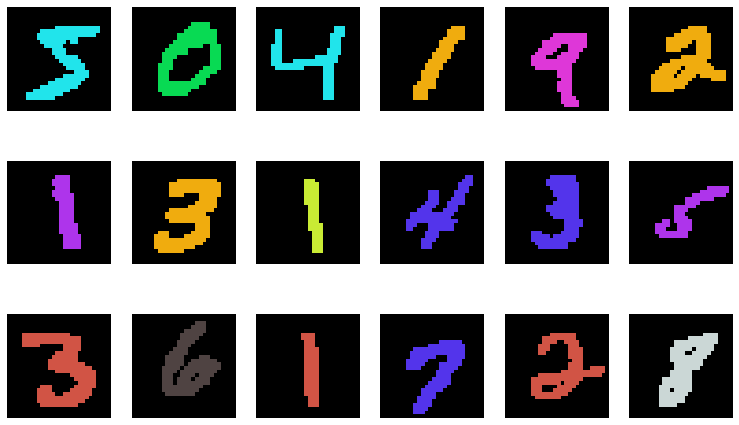

In [ ]:
plot_dataset_digits(train_dataset)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
data_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100,  shuffle=True)

# Eval Continuous VAE

In [ ]:
class Encoder_Continuous(nn.Module):
  def __init__(self, latent_dims):
    super(Encoder_Continuous, self).__init__()
    self.linear1 = nn.Linear(28*28*3, 512)
    self.to_mean_logvar = nn.Linear(512, 2*latent_dims)

  def reparametrization_trick(self, mu, log_var):
    # Using reparameterization trick to sample from a gaussian
    eps = torch.randn_like(log_var)
    return mu + torch.exp(log_var / 2) * eps

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.linear1(x))
    mu, log_var = torch.split(self.to_mean_logvar(x),2, dim=-1)
    self.kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return self.reparametrization_trick(mu, log_var)

In [ ]:
class Decoder_Continuous(nn.Module):
  def __init__(self, latent_dims):
    super(Decoder_Continuous, self).__init__()
    self.linear1 = nn.Linear(latent_dims, 512)
    self.linear2 = nn.Linear(512, 28*28*3)

  def forward(self, z):
    z = F.relu(self.linear1(z))
    z = torch.sigmoid(self.linear2(z))
    return z.reshape((-1, 3, 28, 28))

In [ ]:
class Vae_Continous(nn.Module):
  def __init__(self, latent_dims):
    super().__init__()
    self.encoder = Encoder_Continuous(latent_dims)
    self.decoder = Decoder_Continuous(latent_dims)

  def forward(self, x):
    z = self.encoder(x)
    return self.decoder(z)

In [ ]:
def plot_reconstructed_c(autoencoder,  r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = []
    for i, z2 in enumerate(np.linspace(r1[1],r1[0], n)):
        for j, z1 in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[z1, z2]]).to(device)
            x_hat = autoencoder.decoder(z)
            img.append(x_hat)

    img = torch.cat(img)
    img = torchvision.utils.make_grid(img,nrow=12).permute(1, 2, 0).detach().numpy()
    plt.imshow(img,extent=[*r0, *r1])

In [ ]:
def plot_latent_c(autoencoder, data, num_batches=100):
  for i, (x, y) in enumerate(data):
    z = autoencoder.encoder(x.to(device))
    z = z.to('cpu').detach().numpy()
    plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
    if i > num_batches:
      plt.colorbar()
      break

In [ ]:
def eval_continous():
  plot_latent_c(vae_continous, data_loader)
  plt.show()

  plot_reconstructed_c(vae_continous, r0=(-2, 2), r1=(-2, 2), n=12)
  plt.show()

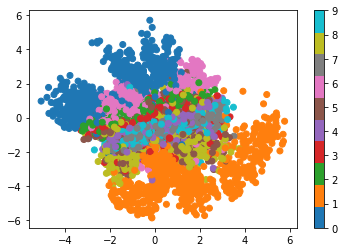

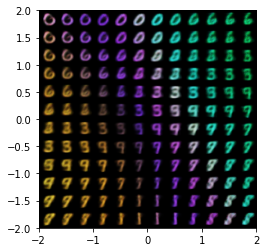

In [ ]:
eval_continous()

# Train Discrete VAE

In [ ]:
def sample_gumbel(shape, eps=1e-20):
    #Sample from Gumbel(0, 1)
    U = torch.rand(shape).float()
    return - torch.log(eps - torch.log(U + eps))

def gumbel_softmax_sample(logits, tau=1, eps=1e-20):
    dims = len(logits.size())
    gumbel_noise = sample_gumbel(logits.size(), eps=eps)
    y = logits + gumbel_noise
    return F.softmax(y / tau, dim=-1)

def gumbel_softmax(logits, tau=1, hard=False, eps=1e-10):

    bs, N,K = logits.size()
    y_soft = gumbel_softmax_sample(logits.view(bs*N,K), tau=tau, eps=eps)

    if hard:
        k = torch.argmax(y_soft, dim=-1)
        y_hard = F.one_hot(k, num_classes=K)

        # 1. makes the output value exactly one-hot
        # 2.makes the gradient equal to y_soft gradient
        y = y_hard - y_soft.detach() + y_soft
    else:
        y = y_soft

    return y.reshape(bs, N*K)

In [ ]:
class DiscreteVAE(nn.Module):
    def __init__(self, latent_dim, categorical_dim):
        super(DiscreteVAE, self).__init__()

        self.fc1 = nn.Linear(784*3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, latent_dim * categorical_dim)

        self.fc4 = nn.Linear(latent_dim * categorical_dim, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, 784*3)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.N = latent_dim
        self.K = categorical_dim

    def encoder(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        return self.relu(self.fc3(h2))

    def decoder(self, z):
        h4 = self.relu(self.fc4(z))
        h5 = self.relu(self.fc5(h4))
        return self.sigmoid(self.fc6(h5))

    def forward(self, x, temp, hard):
        q = self.encoder(x.view(-1, 784*3))
        q_y = q.view(q.size(0), self.N, self.K)
        z = gumbel_softmax(q_y, temp, hard)
        return self.decoder(z), F.softmax(q_y, dim=-1).reshape(q.size(0)*self.N, self.K)

In [ ]:
N = 6
K = 25  # one-of-K vector

temp = 1.0
hard = False
temp_min = 0.5
ANNEAL_RATE = 0.00003

In [ ]:
vae_discrete = DiscreteVAE(N, K).to(device)

optimizer = torch.optim.Adam(vae_discrete.parameters(), lr=1e-3)

In [ ]:
from sklearn.decomposition import PCA

def plot_latent_d(autoencoder, data, num_batches=100):
  for i, (x, y) in enumerate(data):
    z = autoencoder.encoder(x.view(-1, 28*28*3))
    pca = PCA(2)
    projection = pca.fit_transform(z.to('cpu').detach().numpy())

    plt.scatter(projection[:, 0], projection[:, 1], c=y, cmap='tab10')
    if i > num_batches:
      plt.colorbar()
      break

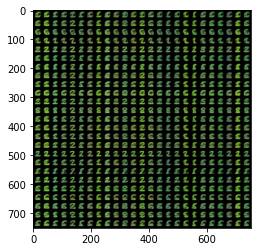

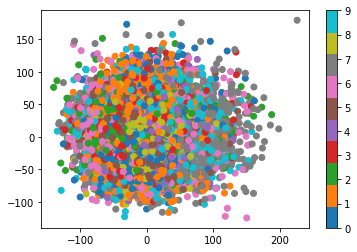

In [ ]:
def eval_discrete():
  ind = torch.zeros(N,1).long()
  images_list = []
  for k in range(K):
      to_generate = torch.zeros(K*K,N,K)
      index = 0
      for i in range(K):
          for j in range(K):

              ind[1]=k
              ind[0]=i
              ind[2]=j
              z = F.one_hot(ind, num_classes=K).squeeze(1)
              to_generate[index]=z
              index += 1

      generate = to_generate.view(-1,K*N)
      reconst_images= vae_discrete.decoder(generate)
      reconst_images = reconst_images.view(reconst_images.size(0), 3, 28, 28).detach()
      grid_img = torchvision.utils.make_grid(reconst_images,nrow=K).permute(1, 2, 0).numpy() * 255
      grid_img = grid_img.astype(np.uint8)
      images_list.append(Image.fromarray(grid_img))

  images_list[0].save('dvae.gif', save_all=True, duration=700, append_images=images_list[1:],loop=10)
  plt.imshow(images_list[3])
  plt.show()

  plot_latent_d(vae_discrete, train_loader)
  plt.show()

In [ ]:
eval_discrete()

# Eval Continuous and Discrete VAE

In [ ]:
def sample_gumbel(shape, eps=1e-20):
    #Sample from Gumbel(0, 1)
    U = torch.rand(shape).float()
    return - torch.log(eps - torch.log(U + eps))

def gumbel_softmax_sample(logits, tau=1, eps=1e-20):
    dims = len(logits.size())
    gumbel_noise = sample_gumbel(logits.size(), eps=eps)
    y = logits + gumbel_noise
    return F.softmax(y / tau, dim=-1)

def gumbel_softmax(logits, tau=1, hard=False, eps=1e-10):

    bs, N,K = logits.size()
    y_soft = gumbel_softmax_sample(logits.view(bs*N,K), tau=tau, eps=eps)

    if hard:
        k = torch.argmax(y_soft, dim=-1)
        y_hard = F.one_hot(k, num_classes=K)

        # 1. makes the output value exactly one-hot
        # 2.makes the gradient equal to y_soft gradient
        y = y_hard - y_soft.detach() + y_soft
    else:
        y = y_soft

    return y.reshape(bs, N*K)

In [ ]:
class VAE_Combined(nn.Module):
  def __init__(self, z_dim,N,K):
    super(VAE_Combined, self).__init__()
    self.fc1 = nn.Linear(3*28*28, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc_to_d = nn.Linear(256, N * K)
    self.fc_to_n = nn.Linear(256, 2*z_dim)

    self.fc3 = nn.Linear(z_dim + N*K, 256)
    self.fc4 = nn.Linear(256, 512)
    self.fc5 = nn.Linear(512, 28*28*3)

    self.N = N
    self.K = K
    self.normal_latent_dim = z_dim

    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()


  def reparametrization_trick(self, mu, log_var):
    eps = torch.randn_like(log_var)
    return mu + torch.exp(log_var / 2) * eps

  def encoder_normal(self, x):
    h1 = F.relu(self.fc1(x))
    h2 = F.relu(self.fc2(h1))
    h3 = self.fc_to_n(h2)
    mu, log_var = torch.split(h3,self.normal_latent_dim, dim=-1)
    kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    z = self.reparametrization_trick(mu, log_var)
    return z,kl

  def encoder_discrete(self, device, x, temp, hard):
    h1 = self.relu(self.fc1(x))
    h2 = self.relu(self.fc2(h1))
    q =  self.relu(self.fc_to_d(h2))
    q_y = q.view(q.size(0), self.N, self.K)
    z = gumbel_softmax(q_y, temp, hard)
    return z, F.softmax(q_y, dim=-1).reshape(q.size(0)*self.N, self.K)

  def encoder_combined(self, device, x, temp, hard):
    input = x.view(-1, 28*28*3)
    z1_cont, kl = self.encoder_normal(input)
    z2_dis, qy = self.encoder_discrete(device, input, temp, hard)
    z_combined = torch.cat((z1_cont, z2_dis), dim = 1)
    return z_combined, qy, kl

  def decoder(self,x):
    output = F.relu(self.fc3(x))
    output = F.relu(self.fc4(output))
    output = self.sigmoid(self.fc5(output))
    output = output.view(-1, 3,28,28)
    return output

  def forward(self, device, input, temp, hard):
    x, qy, kl = self.encoder_combined(device, input, temp, hard)
    x = self.decoder(x)
    return x, qy, kl

In [ ]:
from sklearn.decomposition import PCA

def plot_latent_both(autoencoder, data, num_batches=100):
  for i, (x, y) in enumerate(data):
    output, qy, kl = autoencoder.encoder_combined(device, x.view(-1, 28*28*3),temp, hard)
    pca = PCA(2)
    projection = pca.fit_transform(output.to('cpu').detach().numpy())

    plt.scatter(projection[:, 0], projection[:, 1], c=y, cmap='tab10')
    if i > num_batches:
      plt.colorbar()
      break

In [ ]:
def eval_combined():
    ind = torch.zeros(N,1).long()
    images_list = []
    for k in range(K):
        to_generate = torch.zeros(K*K,N,K)
        index = 0
        for i in range(K):
            for j in range(K):

                ind[1]=k
                ind[0]=i
                ind[2]=j
                z = F.one_hot(ind, num_classes=K).squeeze(1)
                to_generate[index]=z
                index += 1

        generate = to_generate.view(-1,K*N).to(device)
        z_continuous = torch.normal(0, 3, size=(generate.shape[0], z_dim)).to(device)
        generate = torch.cat((z_continuous, generate), dim=1)
        reconst_images= model_combined.decoder(generate)
        reconst_images = reconst_images.view(reconst_images.size(0), 3, 28, 28).detach().cpu()
        grid_img = torchvision.utils.make_grid(reconst_images,nrow=K).permute(1, 2, 0).numpy() * 255
        grid_img = grid_img.astype(np.uint8)
        images_list.append(Image.fromarray(grid_img))

    images_list[0].save('combined.gif', save_all=True, duration=700, append_images=images_list[1:],loop=10)
    plt.imshow(images_list[1])
    plt.show()

    plot_latent_both(model_combined, data_loader)
    plt.show()

In [ ]:
eval_combined()